In [1]:
import os
import numpy as np
import random
import torch
import glob
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import datasets

import pathlib
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def activation_layer(activation:str):

    if activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)


In [4]:
def normalization_layer(normalization: str,
                      num_channels: int, dim:int):
    if dim == 2:
        if normalization == 'BN':
            return nn.BatchNorm2d(num_channels)
    elif dim == 3:
        if normalization == 'BN':
            return nn.BatchNorm3d(num_channels)


In [5]:
def pooling_layer(pooling:str, dim:int):
    if dim == 2:
        if pooling == "max":
            return nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        elif pooling == 'avg':
            return nn.AvgPool2d(kernel_size=2,stride=2,padding=0)

    if dim == 3:
        if pooling == "max":
            return nn.MaxPool3d(kernel_size=2,stride=2,padding=0)
        elif pooling == 'avg':
            return nn.AvgPool3d(kernel_size=2,stride=2,padding=0)


In [6]:
def conv_layer(in_chs, out_chs, kernel_size, stride, padding, dim):
    if dim == 2:
        return nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding)
    elif dim == 3:
        return nn.Conv3d(in_chs, out_chs, kernel_size, stride, padding)

In [7]:
def up_sample_layer(up_sample,in_chs = None, out_chs = None, kernel_size = 2, stride = 2, dim = 3):
    if up_sample == 'transposed':
        if dim == 2:
            return nn.ConvTranspose2d(in_chs, out_chs, kernel_size,stride)
        elif dim == 3:
            return nn.ConvTranspose3d(in_chs, out_chs, kernel_size,stride)
    else:
        return nn.Upsample(scale_factor=2, mode=up_sample) # mode can be 'nearest', 'bilinear' ,...

In [8]:
def Cat(tensor1, tensor2):
    
    x = torch.cat((tensor1, tensor2), 1)

    return x

In [9]:
def Add (tensor1, tensor2):
    
    x = torch.add(tensor1, tensor2)
    
    return x

In [10]:
class DownBlock(nn.Module):
    """
    represent a block of left part of the U shape.
    it contains two convolution layers, 
    each followed by a batch normalization (BN) and a leaky rectified,
    and a downsampling layer followed by a BN and leakyRElu
    
    
    
    """

    def __init__(self,
                 in_ch,
                 out_ch,
                 stride_pooling:bool,
                 pooling: str = "max",     
                 kernel_size: int = 3,
                 stride:int = 1,
                 padding: int = 1,
                 activation: str = 'leaky',
                 normalization: str = 'BN',
                 dim: int = 2
                 ):
        super().__init__()

        self.in_ch = in_ch
        self.out_ch = out_ch
        self.pooling = pooling
        self.stride_pooling = stride_pooling
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        
        self.activation_layer = activation_layer(self.activation)
        self.normalization_layer = normalization_layer(normalization=self.normalization, num_channels=self.out_ch,
                                           dim=self.dim)       
        self.pooling_layer = pooling_layer(pooling = self.pooling, dim=self.dim)
        self.stride_layer = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = 2, padding = self.padding, 
                                          dim = self.dim)
        
        #self.tensor_to_cat = nn.ModuleList()
        self.conv_layer1 = conv_layer(self.in_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        self.conv_layer2 = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)




    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.normalization_layer(x)
        x = self.activation_layer(x)
        x = self.conv_layer2(x)
        x = self.normalization_layer(x)
        x = self.activation_layer(x)
        connect_layer = x
        if self.stride_pooling:
            x = self.stride_layer(x)
            
        else:
            x =  self.pooling_layer(x)
        x = self.normalization_layer(x)
        x = self.activation_layer(x)
                                                       
        return x,connect_layer


In [ ]:
def crop(down_level, up_level):
    """
    the input down_level is each level's last tensor on the left (down) side. e.g. [1,1,256,256,64]; up_level is the first
    tensor on the right (up) side.
    Center-crops the encoder_layer to the size of the decoder_layer,
    so can catanate encoder layer to decoder layer
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if down_level.shape[2:] != up_level.shape[2:]:
        down_shape = down_level.shape[2:]
        up_shape = up_level.shape[2:]
#down_shape should bigger than up_shape
        if down_level.dim() == 4:  # 2D
            down_level = encoder_layer[
                            :,
                            :,
                            ((down_shape[0] - up_shape[0]) // 2):((down_shape[0] + up_shape[0]) // 2),
                            ((down_shape[1] - up_shape[1]) // 2):((down_shape[1] + up_shape[1]) // 2)
                            ]
        elif down_level.dim() == 5:  # 3D
            down_level = down_level[
                            :,
                            :,
                            ((down_shape[0] - up_shape[0]) // 2):((down_shape[0] + up_shape[0]) // 2),
                            ((down_shape[1] - up_shape[1]) // 2):((down_shape[1] + up_shape[1]) // 2),
                            ((down_shape[2] - up_shape[2]) // 2):((down_shape[2] + up_shape[2]) // 2),
                            ]
    return down_level, up_level


In [12]:
class UpBlock(nn.Module):
    """
    it corresponds to "red arrow+blue arrow+ blue arrow", i.e.
    [decon_layer (half the number of channels)+ Upsampling (double image size)]+
    [conv+bn+leaky]+[con+bn+leaky]
    """

    def __init__(self,
                 in_ch,
                 out_ch,
                 concatenate:bool = False,
                 add : bool = False,
                 Crop:bool = False,
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation: str = 'leaky',
                 normalization: str = "BN",
                 dim: int = 3,
                 up_sample: str = 'nearest'
                 ):
        super().__init__()

        self.in_ch =in_ch
        self.out_ch = out_ch
        self.concatenate = concatenate
        self.add = add
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        self.up_sample = up_sample
        self.Crop = Crop
        

    
        self.activation_layer = activation_layer(self.activation)
     
        self.up_sample_layer = up_sample_layer(up_sample = self.up_sample)
        
        self.conv_layer1 = conv_layer(self.in_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        if self.add:
            self.conv_layer2 = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        elif self.concatenate:
            self.conv_layer2 = conv_layer(self.in_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
            self.conv_layer3 = conv_layer(self.out_ch, self.out_ch, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        self.norm_layer = normalization_layer(normalization=self.normalization, num_channels=self.out_ch,
                                           dim=self.dim)        
            
    def forward(self, x, connect_layer):
        """ 

        """
        #deconv + upsample
        x = self.conv_layer1(x) #128 -> 64
        x = self.up_sample_layer(x) # 32*32 -> 64*64
        
        #merge
        if self.concatenate:
            x = Cat(connect_layer,x) #64 -> 128
            x = self.conv_layer2(x) #128->64
            x = self.norm_layer(x) 
            x = self.activation_layer(x)
            x = self.conv_layer3(x) #64 -> 64
            x = self.norm_layer(x)
            x = self.activation_layer(x)
            
        elif self.add:
            x = Add(connect_layer,x)
        
            #conv+bn+lrelu
            x = self.conv_layer2(x)
            x = self.norm_layer(x)
            x = self.activation_layer(x)
            #conv+bn+lrelu
            x = self.conv_layer2(x)
            x = self.norm_layer(x)
            x = self.activation_layer(x)
        
        

        return x


In [30]:
class UNet(nn.Module):
    """
    it combines DownBlock + middle bottom of U shape + UpBlock + the final conv_layer.
    we want to follow the UNet from the paper, so  here depth is 3, which means
    the UNet will first run DownBlock for three times,
    then reach the bottom, and will run "conv+bn+leaky" +"conv+bn+leaky",
    then will run UpBlock for three times,
    then we add the last layer to make channels from 16 -> 1

    """
    def __init__(self,
                 stride_pooling:bool,
                 chs = [1,16,32,64,128],
                 concatenate:bool = False,
                 add:bool = False,
                 Crop:bool=False,
                 pooling = "max",
                 
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation: str = 'leaky',
                 normalization: str = "BN",
                 dim: int = 3,
                 up_sample: str = 'nearest'
                 ):
        super().__init__()

        self.chs = chs
        self.depth = len(chs)-2
        self.pooling = pooling
        self.stride_pooling = stride_pooling
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        self.concatenate = concatenate
        self.add = add
        self.up_sample = up_sample
        self.Crop = Crop
        
        
        self.encoder = nn.ModuleList([])
        self.decoder = nn.ModuleList([])
        for i in range(self.depth):
            encoder_layer = DownBlock(
                 in_ch=self.chs[i],
                 out_ch=self.chs[i+1],
                 #concatenate = True,
                 stride_pooling = self.stride_pooling,
                 pooling = self.pooling,
                 kernel_size = self.kernel_size,
                 stride = self.stride,
                 padding = self.padding,
                 activation = self.activation,
                 normalization = self.normalization,
                 dim= self.dim)
            
            self.encoder.append(encoder_layer)
            
            decoder_layer = UpBlock(
                 in_ch = self.chs[-1-i],
                 out_ch = self.chs[-2-i],
                 concatenate= self.concatenate,
                 add = self.add,
                 Crop=self.Crop,
                 kernel_size = self.kernel_size,
                 stride = self.stride,
                 padding = self.padding,
                 activation= self.activation,
                 normalization = self.normalization,
                 dim = self.dim,
                 up_sample= self.up_sample) 
            
            self.decoder.append(decoder_layer)
            
        self.set_weights()
        

    @staticmethod        
    def weight_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            #nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('Sigmoid') != -1:
            nn.init.xavier_normal(m.weight)
        #elif classname.find('Leaky') != -1:
            #nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        elif classname.find('Linear') != -1:
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
   
    def set_weights(self):
        for i,m in enumerate(self.modules()):
            self.weight_init(m)
            
        
    def forward(self,x):
        connect_list = [] #it contains the layer from encoder path which need to skip to connect
        
        #encoder path
        for i in range(self.depth):
            block = self.encoder[i]
            x,connect_layer = block(x)
            connect_list.append(connect_layer)
            
        #bottom block: the middle and bottom part of UNet
        
        act_layer = activation_layer(self.activation)
        conv_layer1 = conv_layer(self.chs[-2], self.chs[-1], kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)          
        conv_layer2 = conv_layer(self.chs[-1], self.chs[-1], kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        norm_layer = normalization_layer(normalization=self.normalization, num_channels=self.chs[-1],
                                           dim=self.dim)  
        x = conv_layer1(x)
        x = norm_layer(x)
        x = act_layer(x)
        x = conv_layer2(x)
        x = norm_layer(x)
        x = act_layer(x)
        
        #decoder path
        for i in range(self.depth):
            layer_to_connect = connect_list[-1-i]
            block = self.decoder[i]
            x = block(x,layer_to_connect)
            
        #last layer : 16 to 1
        
        
        conv_layer_final = conv_layer(self.chs[1], self.chs[0], kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
        norm_layer_final = normalization_layer(normalization=self.normalization, num_channels=self.chs[0],
                                           dim=self.dim) 
        x = conv_layer_final(x)
        x = norm_layer_final(x)
        x = act_layer(x)
        #x = nn.Sigmoid()(x)
        #x = nn.Linear(256,256)(x)
            
        return x
                
            

In [31]:
model_unet = UNet(chs = [1,16,32,64,128],
                 concatenate= False, 
                 add = True,
                 Crop=False,
                 pooling = "max",
                 stride_pooling = True, #if stride_pooling = True, than up_sample method will be conv_layer (stride=2)
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                  
                 activation= 'leaky',
                 normalization = "BN",
                 dim= 2,
                 up_sample = 'nearest').to(device)

C:\Users\h\anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [15]:
from torchsummary import summary
summary(model_unet, (1,256,256), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 16, 256, 256]             160
       BatchNorm2d-2          [1, 16, 256, 256]              32
         LeakyReLU-3          [1, 16, 256, 256]               0
            Conv2d-4          [1, 16, 256, 256]           2,320
       BatchNorm2d-5          [1, 16, 256, 256]              32
         LeakyReLU-6          [1, 16, 256, 256]               0
            Conv2d-7          [1, 16, 128, 128]           2,320
       BatchNorm2d-8          [1, 16, 128, 128]              32
         LeakyReLU-9          [1, 16, 128, 128]               0
        DownBlock-10  [[-1, 16, 128, 128], [-1, 16, 256, 256]]               0
           Conv2d-11          [1, 32, 128, 128]           4,640
      BatchNorm2d-12          [1, 32, 128, 128]              64
        LeakyReLU-13          [1, 32, 128, 128]               0
           Conv2d-14    

In [ ]:
torch.save(model_unet, "UNet.pth")



In [ ]:
model_unet = torch.load("UNet.pth")

# upload image and noise

In [16]:
from scipy.io import loadmat
P = loadmat('xcat.mat')
p = P['data']


In [17]:
p1 = p[:,:,120,2] #this give the chest image at time 2
#P1= torch.from_numpy(p1)
#P1 = P1.unsqueeze(0)
#P1 = P1.unsqueeze(0)

In [18]:
transformer = transforms.Compose([
 #0-1, numpy to tensor
    transforms.ToTensor(),
    transforms.Normalize(0.5,
                        0.5) # 0-1 to -1,1 and normalized
])
p2 = (p1-p1.min())/(p1.max()-p1.min())# scale to (0,1)
p2 = transformer(p2)#scale to (-1,1)
P = p2.unsqueeze(0)
noise = np.clip(np.random.normal(scale=50, size=(256,256)), 0, 1).astype(np.float32) #scale to (0,1)
noise_tensor = transformer(noise) #(-1,1)
noise = noise_tensor.unsqueeze(0)

#poisson_noise = torch.poisson(P1)*0.01
#image = P+poisson_noise

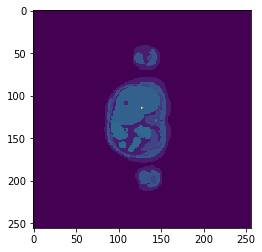

In [19]:
plt.imshow(P[0,0,:,:])

In [ ]:
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()


# train function

In [52]:
def optim(optimizer:str = 'Adam'):
    if optimizer == 'Adam':
        return Adam(model.parameters(), lr=1e-2)
    elif optimizer == 'SGD':
        return torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [35]:
def loss(criterion:str = 'MSE'):
    if criterion == 'MSE':
        return nn.MSELoss()

In [53]:
def train_setup(model,criterion_name,optimizer_name,input_image,label_image,epoch):
    optimizer = optim(optimizer_name)
    criterion = loss(criterion_name)


    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        
    def train(epoch):
    #strat TRAIN mode
        model.train()
        train_loss = 0.0
        
        x_train, label= Variable(input_image), Variable(label_image)
    

        if torch.cuda.is_available():
        
            x_train = x_train.cuda()           
            label = label.cuda()
    
        optimizer.zero_grad()
        output = model(x_train)
        output_img = output.detach().numpy()
        
        loss = criterion(output,label)
    #compute gradient
        loss.backward()
    #update parameters
        optimizer.step()    
         
    
        train_loss = loss.item()
        loss_list.append(train_loss)
        
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
        
        
        if (epoch+1) %200 == 0:  #this only display the output of tevery 200 iteration
            fig.add_subplot(1,4,(epoch+1)/200)
            plt.imshow(output_img[0,0,:,:])
            plt.clim(0,1)
    
    return train(epoch)
    
 

#  training process

In [54]:
model = model_unet
criterion_name = 'MSE'
optimizer_name = 'Adam'
#input_image = P1+ poisson_noise

input_image = noise
label_image = P

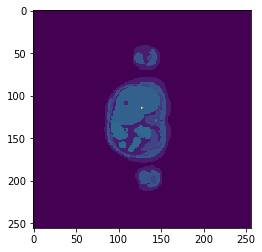

In [29]:
plt.imshow(P[0,0,:,:])

Epoch: 0 	Training Loss: 1.418437
Epoch: 1 	Training Loss: 1.618840
Epoch: 2 	Training Loss: 1.963628
Epoch: 3 	Training Loss: 1.446347
Epoch: 4 	Training Loss: 1.557255
Epoch: 5 	Training Loss: 1.224422
Epoch: 6 	Training Loss: 1.725861
Epoch: 7 	Training Loss: 1.130800
Epoch: 8 	Training Loss: 1.205482
Epoch: 9 	Training Loss: 1.883420
Epoch: 10 	Training Loss: 1.306929
Epoch: 11 	Training Loss: 1.074136
Epoch: 12 	Training Loss: 1.058003
Epoch: 13 	Training Loss: 1.825270
Epoch: 14 	Training Loss: 1.950434
Epoch: 15 	Training Loss: 1.926559
Epoch: 16 	Training Loss: 1.095921
Epoch: 17 	Training Loss: 1.862502
Epoch: 18 	Training Loss: 1.770269
Epoch: 19 	Training Loss: 2.003196
Epoch: 20 	Training Loss: 1.261561
Epoch: 21 	Training Loss: 1.357326
Epoch: 22 	Training Loss: 1.946739
Epoch: 23 	Training Loss: 1.102016
Epoch: 24 	Training Loss: 1.084922
Epoch: 25 	Training Loss: 1.988729
Epoch: 26 	Training Loss: 1.983600
Epoch: 27 	Training Loss: 1.896409
Epoch: 28 	Training Loss: 1.19

Epoch: 231 	Training Loss: 1.826106
Epoch: 232 	Training Loss: 1.171068
Epoch: 233 	Training Loss: 1.275573
Epoch: 234 	Training Loss: 1.092773
Epoch: 235 	Training Loss: 1.951706
Epoch: 236 	Training Loss: 1.646363
Epoch: 237 	Training Loss: 1.087131
Epoch: 238 	Training Loss: 1.960602
Epoch: 239 	Training Loss: 1.922763
Epoch: 240 	Training Loss: 1.199711
Epoch: 241 	Training Loss: 1.948118
Epoch: 242 	Training Loss: 1.024020
Epoch: 243 	Training Loss: 1.956638
Epoch: 244 	Training Loss: 1.917298
Epoch: 245 	Training Loss: 1.322894
Epoch: 246 	Training Loss: 1.236324
Epoch: 247 	Training Loss: 1.916451
Epoch: 248 	Training Loss: 1.949618
Epoch: 249 	Training Loss: 1.037632
Epoch: 250 	Training Loss: 1.897528
Epoch: 251 	Training Loss: 1.004283
Epoch: 252 	Training Loss: 1.923682
Epoch: 253 	Training Loss: 1.096002
Epoch: 254 	Training Loss: 0.988170
Epoch: 255 	Training Loss: 1.258126
Epoch: 256 	Training Loss: 0.979630
Epoch: 257 	Training Loss: 1.135734
Epoch: 258 	Training Loss: 1

Epoch: 459 	Training Loss: 1.186508
Epoch: 460 	Training Loss: 1.645742
Epoch: 461 	Training Loss: 1.808079
Epoch: 462 	Training Loss: 1.485113
Epoch: 463 	Training Loss: 1.234737
Epoch: 464 	Training Loss: 1.838593
Epoch: 465 	Training Loss: 1.243891
Epoch: 466 	Training Loss: 1.484716
Epoch: 467 	Training Loss: 1.644082
Epoch: 468 	Training Loss: 1.614137
Epoch: 469 	Training Loss: 1.972775
Epoch: 470 	Training Loss: 1.947451
Epoch: 471 	Training Loss: 1.918694
Epoch: 472 	Training Loss: 1.960459
Epoch: 473 	Training Loss: 1.965254
Epoch: 474 	Training Loss: 1.193631
Epoch: 475 	Training Loss: 1.113037
Epoch: 476 	Training Loss: 1.960165
Epoch: 477 	Training Loss: 1.162019
Epoch: 478 	Training Loss: 1.038839
Epoch: 479 	Training Loss: 1.027342
Epoch: 480 	Training Loss: 1.474438
Epoch: 481 	Training Loss: 1.700420
Epoch: 482 	Training Loss: 1.952281
Epoch: 483 	Training Loss: 1.509175
Epoch: 484 	Training Loss: 1.753761
Epoch: 485 	Training Loss: 1.195924
Epoch: 486 	Training Loss: 1

Epoch: 687 	Training Loss: 1.481956
Epoch: 688 	Training Loss: 1.948256
Epoch: 689 	Training Loss: 1.562581
Epoch: 690 	Training Loss: 1.870414
Epoch: 691 	Training Loss: 1.536087
Epoch: 692 	Training Loss: 1.929144
Epoch: 693 	Training Loss: 1.657088
Epoch: 694 	Training Loss: 1.392428
Epoch: 695 	Training Loss: 1.765832
Epoch: 696 	Training Loss: 1.249947
Epoch: 697 	Training Loss: 1.521100
Epoch: 698 	Training Loss: 1.636809
Epoch: 699 	Training Loss: 1.424533
Epoch: 700 	Training Loss: 1.246810
Epoch: 701 	Training Loss: 1.600419
Epoch: 702 	Training Loss: 1.012852
Epoch: 703 	Training Loss: 1.057268
Epoch: 704 	Training Loss: 1.919802
Epoch: 705 	Training Loss: 1.543325
Epoch: 706 	Training Loss: 1.943945
Epoch: 707 	Training Loss: 1.247730
Epoch: 708 	Training Loss: 1.924524
Epoch: 709 	Training Loss: 1.002203
Epoch: 710 	Training Loss: 1.944546
Epoch: 711 	Training Loss: 1.018964
Epoch: 712 	Training Loss: 1.754839
Epoch: 713 	Training Loss: 1.010848
Epoch: 714 	Training Loss: 1

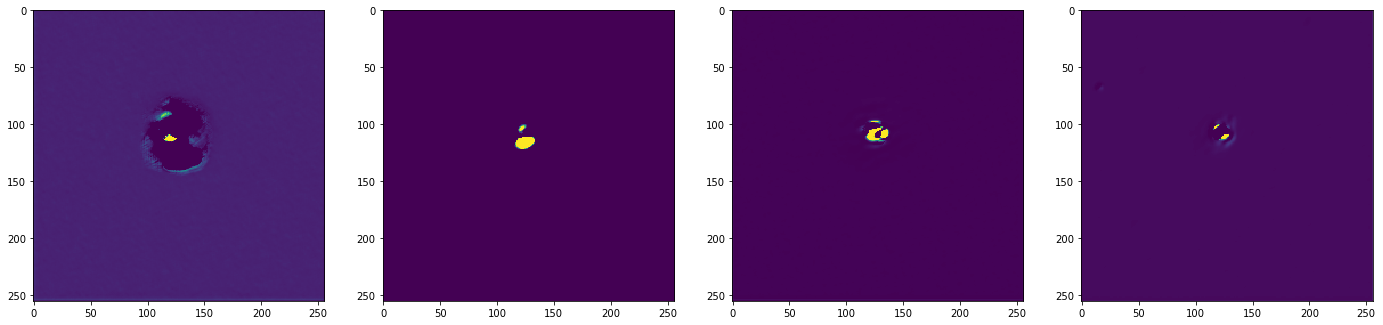

In [55]:
num_epochs = 800
train_loss = 0
loss_list = []
#rows = math.ceil(num_epochs/4)
#fig = plt.figure(figsize=(rows*3,4*3))
fig = plt.figure(figsize=(24,24))

#fig.tight_layout()
#plt.subplots_adjust(wspace =0, hspace =0)

for epoch in range(num_epochs):
    train_setup(model,criterion_name,optimizer_name,input_image,label_image,epoch)
    #plt.imshow(output_img[0,0,:,:])
    #ax.set_title(classes[train_labels[idx]])
    #train1(epoch)
#draw loss plot
#plt.plot(loss_list,label='Training loss')

(0.5, 2.5)

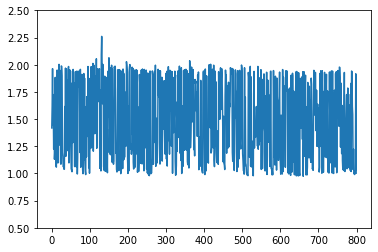

In [58]:
plt.plot(loss_list,label='Training loss')

plt.ylim((0.5,2.5))

# the following are simplified training process, keep it here in case need in the future

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
def train1(epoch):
    #strat TRAIN mode
    model.train()
    train_loss = 0.0
        
    x_train, label= Variable(input_image), Variable(label_image)
    

    if torch.cuda.is_available():
        
        x_train = x_train.cuda()           
        label = label.cuda()
    
    optimizer.zero_grad()    
    
    output = model(x_train)
    output_img = output.detach().numpy()
    
        
    loss = criterion(output,label)
    #compute gradient
    loss.backward()
    #update parameters
    optimizer.step()    

    
    train_loss += loss.item()
    loss_list.append(train_loss)
        
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
        
        #fig.add_subplot(rows,4,epoch+1)
        #plt.imshow(output_img[0,0,:,:])
        #plt.clim(0,1)

In [ ]:
for epoch in range (num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(input_image)
    loss = criterion(output,label_image)
    train_loss = loss.item()
    loss.backward()
    optimizer.step()

        
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
        
        #fig.add_subplot(rows,4,epoch+1)
        #plt.imshow(output_img[0,0,:,:])
        #plt.clim(0,1)
    